# Protein nanobarcodes enable single-step multiplexed fluorescence imaging

This notebook contains the code necessary for setting up the deep neural network and dataset manager that are used in the preprint for producing the reported results. Current setup in the code loads hyperparameters and network weights from the ```./data directory```. The flags in the code can easily be changed to retrain and save the network.

This notebook depends on local installations of these libraries

 - **PyTorch** with CUDA enabled for network training/prediction on the GPU
 - **numpy** for arrays and numerical computations
 - **scipy** for signal processing functions
 - **matplotlib** for plotting
 - **scikit-image** for image processing
 - **tifffile** for image IO
 - **tqdm** for progress tracking

This notebook additionally relies on the included custom library ```./dnn_classifier``` for network and data handler components.

In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt, colors as mcol
from matplotlib.ticker import PercentFormatter
from skimage import restoration, morphology
import tifffile
import pickle
from tqdm.notebook import tqdm

### Importing the dnn_classifier library, which initially does a check on PyTorch installation and CUDA availability:

In [2]:
from dnn_classifier import network_components as nc
from dnn_classifier import network_main as net_main
from dnn_classifier import dataset_handler as dat
from dnn_classifier import model

Is cuda available: True
CUDA version: 11.1
PyTorch version: 1.8.2
Cuda device name: GeForce RTX 3090


In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable

### Setting up IO paths, as well as specifying which staining/imaging condition among the available training data is used:

In [4]:
data_dir = "./data"
output_dir = "./output"
save_net_dir = "./saved_networks"

expression_times = ["overnight", "24h", "48h", "72h"]
gains = ["500", "550", "650"]
    
dataset_expression_time = expression_times[2]
dataset_scaling = ["fixed", "linear", "whitened", "channel_whitened"][2]
dataset_gain = gains[1]

ext_str = f"{dataset_expression_time}_{dataset_scaling}_gain_{dataset_gain}"

save_net_file_name = f"{save_net_dir}/confocal_channel_net_12_trained_on_{ext_str}.pth"
dataset_file_name = f"{data_dir}/dataset_{ext_str}.pkl"

### The data_handler object manages input training data, its shuffling, train/test split, and data augmentation:

In [5]:
data_handler = dat.MyFluorophoreDataset(brightness_data_file_name=dataset_file_name,
                                        do_brightness_augmentation=True,
                                        brightness_augmentation_factor=0.5)

loading data from ./data/dataset_48h_whitened_gain_550.pkl...
Brightness data loaded for: 
['ENDO', 'GFP', 'GalNact', 'KDEL', 'LifeAct', 'NLS', 'SNAP25', 'STX4', 'STX6', 'TOM70', 'Vti1a', 'Blank']
Data for ENDO with id 0
Brightness data size: (10, 10000)
Brightness data mean: [19.93811878  0.56710862 -0.45895377  0.4934034  -0.23254554 -0.46590337
  0.38094219 -0.47891174  0.56880784  4.54984968]
Brightness data std: [8.48000139 0.52754128 0.11464239 0.19398426 0.23991347 0.11307262
 0.1476165  0.10849178 0.2361253  2.40189448]
Data for GFP with id 1
Brightness data size: (10, 10000)
Brightness data mean: [ 0.73974189 -0.56565823 -0.91983484  1.15317799  1.02045599 -0.81738613
  1.13786057 -0.97616168  1.14850053  1.49947379]
Brightness data std: [0.64342297 0.42784643 0.1393923  0.11626102 1.21123529 0.209408
 0.10617936 0.07850074 0.12189462 0.40905904]
Data for GalNact with id 2
Brightness data size: (10, 10000)
Brightness data mean: [29.44902111  1.05152007 -0.55393571  0.59198036 

### Getting names of labeled proteins from the dataset:

In [6]:
print(data_handler.id_to_protein_name)

['ENDO', 'GFP', 'GalNact', 'KDEL', 'LifeAct', 'NLS', 'SNAP25', 'STX4', 'STX6', 'TOM70', 'Vti1a', 'Blank']


### Checking the training data for a specified channel and protein (feel free to change): 

In [7]:
channel_ind = 8
protein_ind = 3

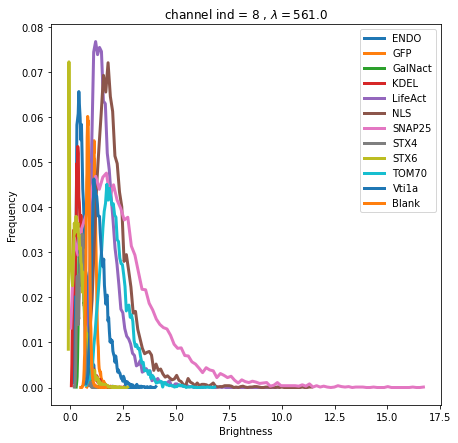

In [8]:
plt.figure(figsize=(7, 7))

for _pr in data_handler.protein_names:
    
    data = data_handler.brightness_data[_pr]["data"][channel_ind, :]
    
    hist, bin_edges = np.histogram(data, bins=100)
    hist = hist / np.sum(hist)
    plt.plot(bin_edges[:-1], hist, label=_pr, linewidth=3)

plt.title(r"channel ind = " + str(channel_ind) +" , $\lambda = $" + str(dat.channel_wavelength[channel_ind]))
plt.ylabel('Frequency')
plt.xlabel('Brightness')

plt.legend()

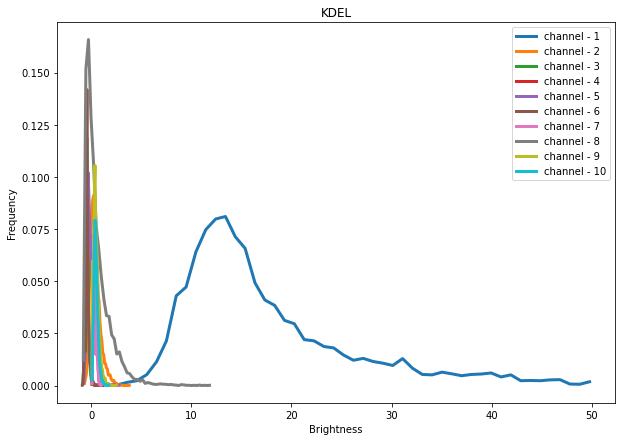

In [9]:
protein_name = data_handler.id_to_protein_name[protein_ind]

plt.figure(figsize=(10, 7))

for i in range(dat.n_channels):
    
    data = data_handler.brightness_data[protein_name]["data"][i]

    hist, bin_edges = np.histogram(data, bins=50)
    hist = hist / np.sum(hist)
    
    plt.plot(bin_edges[:-1], hist, label='channel - ' + str(i + 1), linewidth=3)

plt.title(protein_name)
plt.ylabel('Frequency')
plt.xlabel('Brightness')

plt.legend()

### Boolean flags controlling the behavior of the rest of the notebook:

In [10]:
save_net = False
load_net = True
train_net = False
save_figures = True

### Loading network hyperparameters from file:

In [11]:
best_parameters = np.load(save_net_dir + '/optimized_hyperparams.npy', allow_pickle=True).item()

print(best_parameters)

{'width': 64, 'n_middle_layers': 3, 'resnet_stride': 3, 'cardinality': 4, 'batch_size': 458, 'lr': 0.00014860544347674695, 'use_resnet': True, 'use_dropout': False, 'dropout_rate': 0.2, 'use_bn': True}


### Setting up the network using the ```model_factory```:

In [12]:
net, train_loader, test_loader, optimizer = model.model_factory(data_handler, *model.separate_args(best_parameters))

print(net)

FluorophoreClassifierNet(
  (initial_layers): ModuleList(
    (0): Linear(in_features=10, out_features=37, bias=True)
    (1): MyActivationBlock(
      (activation): ReLU()
      (dropout): Identity()
      (batch_norm): BatchNorm1d(37, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Linear(in_features=37, out_features=64, bias=True)
    (3): MyActivationBlock(
      (activation): ReLU()
      (dropout): Identity()
      (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (middle_layers): ModuleList(
    (0): ModuleList(
      (0): MyResNetBlock(
        (identity): Identity()
        (layer): ModuleList(
          (0): Linear(in_features=64, out_features=64, bias=False)
          (1): Linear(in_features=64, out_features=64, bias=False)
          (2): Linear(in_features=64, out_features=64, bias=False)
        )
        (activation): ModuleList(
          (0): MyActivationBlock(
            (activation

### Checking the training data again for the protein with the index ```protein_ind```, loaded from the augmented set provided by the data iterator:

(439, 10)
[11.815033   -0.4719961  -0.67544097  0.6657398   0.13704266 -0.5860287
  0.7603353   0.17073396  0.80957663  0.94952595]
tensor([ 0.0129,  0.0684,  0.2883, -0.2175,  0.0182, -0.0309, -0.2396, -0.4359,
        -0.1053,  0.0682,  0.0115, -0.0924], device='cuda:0',
       grad_fn=<SelectBackward>)
3


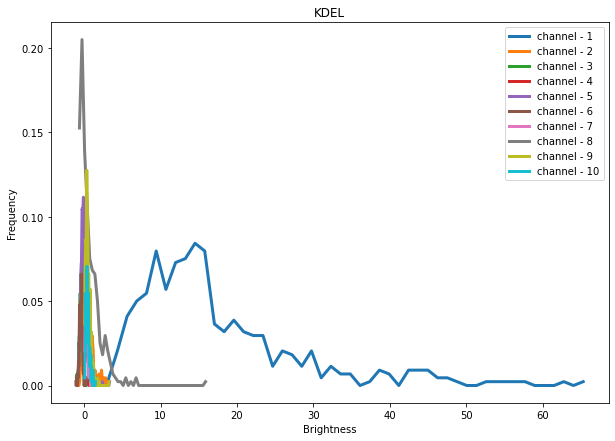

In [13]:
plt.figure(figsize=(10, 7))

br_data = []

dataiter = iter(train_loader)

for i in range(20):

    input_dat, target_dat = dataiter.next()

    for _input, _target in zip(input_dat.cpu().numpy(), target_dat.cpu().numpy()):
        
        if _target == protein_ind:
             br_data.append(_input.copy())
    
br_data = np.array(br_data)
print(br_data.shape)

for i in range(dat.n_channels):
    
    hist, bin_edges = np.histogram(br_data[:, i], bins=50)
    hist = hist / np.sum(hist)
    
    plt.plot(bin_edges[:-1], hist, label='channel - ' + str(i + 1), linewidth=3)

plt.title(data_handler.protein_names[protein_ind])
plt.ylabel('Frequency')
plt.xlabel('Brightness')

plt.legend()

output = net(torch.tensor(br_data).to(nc.cuda_0))

print(br_data[0])
print(output[0])
print(protein_ind)

In [14]:
if load_net:
    net.load_state_dict(torch.load(save_net_file_name))

In [15]:
for param_group in optimizer.param_groups:
    lr0 = param_group['lr']

epoch = 0
overfit = 0

In [16]:
cost_function = nn.CrossEntropyLoss()

train_loss_list = []
test_loss_list = []
accuracy_list = []

if train_net:
    
    while overfit < 10 and epoch < 120:
        
        epoch += 1

        train_loss = model.do_step(net, train_loader, cost_function, optimizer, do_train=True)
        test_loss = model.do_step(net, test_loader, cost_function, None, do_train=False)
    
        if train_loss < 0.75 * test_loss:
            overfit += 1
            print("overfit alert!")
        
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr0 * (2.0 - epoch / 60.0)
            print(f"lr = {param_group['lr']}")
    
        avg_test_accuracy = model.calc_accuracy(net, test_loader, data_handler.n_proteins, full_output=False)

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)    
        accuracy_list.append(avg_test_accuracy)

        print("epoch: {:d} -- train loss : {:7.5f} -- test loss : {:7.5f} -- accuracy : {:4.2f}%"
              .format(epoch, train_loss, test_loss, avg_test_accuracy * 100.0))

In [17]:
if train_net:
    fig1 = plt.figure()
    plt.plot(train_loss_list, linewidth=2, label='train')
    plt.plot(test_loss_list, linewidth=2, label= 'test')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.yscale('log')

    fig2 = plt.figure()
    plt.plot(np.array(accuracy_list) * 100.0, linewidth=2, label='test')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    if save_figures and (not load_net):

        fig1.savefig(output_dir + '/loss_iter_trained_on_' + ext_str + '.pdf',
                    format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

        fig2.savefig(output_dir + '/accuracy_iter_trained_on_' + ext_str + '.pdf',
                    format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

In [18]:
if save_net:
    torch.save(net.state_dict(), save_net_file_name)

In [19]:
if load_net:
    net.load_state_dict(torch.load(save_net_file_name))

### Checking the prediction accuracy on training and test sets:

In [20]:
avg_accuracy, class_accuracy, false_positive, false_negative = model.calc_accuracy(net, train_loader,
                                                                                  data_handler.n_proteins,
                                                                                  full_output=True)

print(f"Training accuracy = {avg_accuracy * 100.0} %")

Training accuracy = 96.53458849356909 %


In [21]:
avg_accuracy, class_accuracy, false_positive, false_negative = model.calc_accuracy(net, test_loader,
                                                                                   data_handler.n_proteins,
                                                                                   full_output=True)

print(f"Test accuracy = {avg_accuracy * 100.0} %")

print()

print("{:32s} \t {} \t {} \t {}".format("Sequence name", "Accuracy (%)", "False positive (%)", "False negative (%)"))
print("-" * 100)

for protein_name in data_handler.protein_names:
    
    
    protein_id = data_handler.brightness_data[protein_name]["ID"]
    
    print("{:32s} \t {:5.2f} \t  \t \t{:5.2f} \t  \t \t{:5.2f}"
          .format(protein_name, class_accuracy[protein_id] * 100.0,
                 false_positive[protein_id] * 100.0, false_negative[protein_id] * 100.0))

Test accuracy = 96.66974366257189 %

Sequence name                    	 Accuracy (%) 	 False positive (%) 	 False negative (%)
----------------------------------------------------------------------------------------------------
ENDO                             	 88.91 	  	 	24.80 	  	 	16.28
GFP                              	 93.28 	  	 	 4.62 	  	 	 9.59
GalNact                          	 91.50 	  	 	 6.04 	  	 	12.22
KDEL                             	 96.27 	  	 	 4.34 	  	 	 5.40
LifeAct                          	 92.53 	  	 	 8.24 	  	 	10.80
NLS                              	 95.11 	  	 	 4.41 	  	 	 6.89
SNAP25                           	 99.90 	  	 	 0.00 	  	 	 0.14
STX4                             	 96.41 	  	 	15.21 	  	 	 5.19
STX6                             	 83.10 	  	 	14.14 	  	 	24.38
TOM70                            	 99.22 	  	 	 2.27 	  	 	 1.07
Vti1a                            	 98.23 	  	 	 4.69 	  	 	 2.49
Blank                            	 99.61 	  	 	11.23 	  	

### Assigning falser colors to labeled proteins:

In [22]:
def mpl_color (color_name):

    hex_color = mcol.get_named_colors_mapping()[color_name]
    h = hex_color.lstrip('#')
    
    rgbs = list(float(int(h[i:i + 2], 16)) / 255.0 for i in (0, 2 ,4))
    rgbs.append(1.0)
    
    return rgbs

protein_color = dict()

protein_color["Vti1a"] = mpl_color('xkcd:magenta')
protein_color["GFP"] = mpl_color('xkcd:lime')
protein_color["TOM70"] = mpl_color('xkcd:lilac')
protein_color["SNAP25"] = mpl_color('xkcd:burgundy')
protein_color["STX4"] = mpl_color('xkcd:dark orange')
protein_color["STX6"] = mpl_color('xkcd:light red')
protein_color["LifeAct"] = mpl_color('xkcd:dark sky blue')
protein_color["NLS"] = mpl_color('xkcd:dark yellow')
protein_color["KDEL"] = mpl_color('xkcd:moss')
protein_color["GalNact"] = mpl_color('xkcd:beige')
protein_color["ENDO"] = mpl_color('xkcd:bright yellow')
protein_color["Blank"] = np.array([0.0, 0.0, 0.0, 1.0])

edge_color = np.array([0.3, 0.3, 0.3, 1.0])

for protein_name in data_handler.protein_names:
    assert list(protein_color.keys()).index(protein_name) != -1

### Plots of accuracy and false positive/negative predictions per protein:

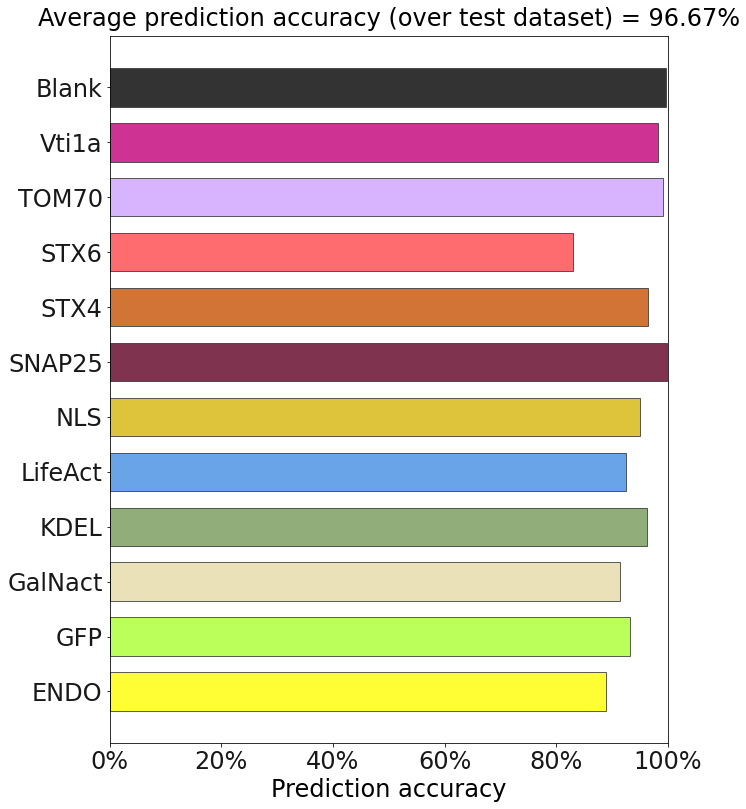

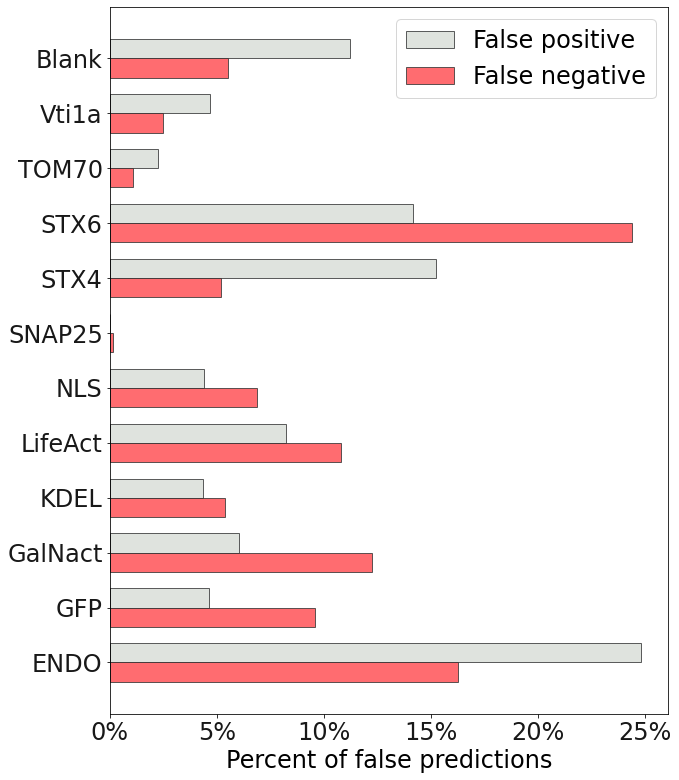

In [23]:
bar_width = 0.35

fig1 = plt.figure(figsize=(10, 13))

for protein_name in data_handler.protein_names:
    
    protein_id = data_handler.brightness_data[protein_name]["ID"]
    
    plt.barh(protein_name, class_accuracy[protein_id] * 100.0,
             color=protein_color[protein_name], edgecolor='xkcd:dark gray', linewidth=1,
             height=bar_width * 2.0, alpha=0.8)

plt.xlim(0.0, 100.0)
plt.yticks(fontsize=24, alpha=0.9)
plt.xticks(rotation=0, fontsize=24, alpha=0.9)

fig1.gca().xaxis.set_major_formatter(PercentFormatter())
plt.xlabel("Prediction accuracy", fontsize=24)

plt.title("Average prediction accuracy (over test dataset) = {:4.2f}%".format(avg_accuracy * 100.0), fontsize=24, pad=10)

fig2 = plt.figure(figsize=(10, 13))
ax2 = fig2.gca()

fp_bars = plt.barh(np.arange(data_handler.n_proteins) + 0.5 * bar_width, false_positive * 100.0,
                   color='xkcd:light gray', height=bar_width, linewidth=1, alpha=0.8, edgecolor='xkcd:dark gray',
                   label='False positive')

fn_bars = plt.barh(np.arange(data_handler.n_proteins) - 0.5 * bar_width, false_negative * 100.0,
                   color='xkcd:light red', height=bar_width, linewidth=1, alpha=0.8, edgecolor='xkcd:dark gray',
                  label='False negative')

plt.xticks(fontsize=24, alpha=0.9)

ax2.set_yticks(np.arange(data_handler.n_proteins))
ax2.set_yticklabels(data_handler.protein_names, fontsize=24, alpha=0.9)

ax2.xaxis.set_major_formatter(PercentFormatter(decimals=0))

plt.legend(fontsize=24)

plt.xlabel("Percent of false predictions", fontsize=24)
    
if save_figures:

    fig1.savefig(f"{output_dir}/prediction_accuracy_trained_on_{ext_str}.pdf",
                format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)    
    
    fig2.savefig(f"{output_dir}/prediction_false_positve_negative_trained_on_{ext_str}.pdf",
                format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)    

### Helper functions for different possible brightness scaling of the training/testing data:

In [24]:
def scale_image_fixed(image):
    
    return image / 65535.0

def scale_image_linear(image):
    
    _max = np.amax(image)
    _min = np.amin(image)
    
    if _max > _min:
        return (image - _min) / (_max - _min)
    else:
        return image - _min

def scale_image_whitened(image):
    
    return (image - np.mean(image)) / np.std(image)

def scale_image_channel_whitened(image):
    
    _im = image.copy()
    
    channel_mean = np.mean(image, axis=1)
    channel_std = np.std(image, axis=1)
    
    assert _im.shape[0] == 10
    
    for i in range(_im.shape[0]):
        _im[i, :] = (_im[i, :] - channel_mean[i]) / channel_std[i]

    return _im

### Function for enhancement of the brightfield image and extraction of "cell halos":

In [25]:
def get_cell_background(brightfield_image):
            
        brightfield_image = (brightfield_image - np.mean(brightfield_image)) / np.std(brightfield_image)

        bff = np.fft.fft2(brightfield_image)

        window = sp.signal.windows.gaussian(brightfield_image.shape[0], std=170.0)
        window = np.outer(window, window)

        bff *= window

        brightfield_image_enhanced = scale_image_linear(np.exp(-scale_image_linear(np.real(np.fft.ifft2(bff))) ** 2 / 0.2))

        seed = np.copy(brightfield_image_enhanced)
        seed[1:-1, 1:-1] = brightfield_image_enhanced.min()
        mask = brightfield_image_enhanced

        dilated = morphology.reconstruction(seed, mask, method='dilation')
        cells = np.clip((scale_image_linear(brightfield_image_enhanced - dilated) - 0.03) * 200.0, 0.0, 1.0)

        cells = restoration.denoise_tv_bregman(cells, weight=0.4)

        return cells

### The ```ContrastModifier``` is a secondary network that adjusts the constrast of input data in an unsupervised manner via minimizing the "entropy" of category probabilities.

In [26]:
class ContrastModifier(nn.Module):

    def __init__(self):

        super(ContrastModifier, self).__init__()
        
        self.mu = nn.Parameter(torch.zeros(dat.n_channels, dtype=torch.float32, device=nc.cuda_0), requires_grad=True)
        self.sig = nn.Parameter(torch.ones(dat.n_channels, dtype=torch.float32, device=nc.cuda_0), requires_grad=True)
        
    def forward(self, x):

        return self.sig * (x - self.mu)
    
def feed_to_network(image_slice_scaled, n_optim_iter):
    
    _im = image_slice_scaled.copy().reshape(dat.n_channels, -1).transpose().astype(np.float32)

    normalizing_layer = nn.Softmax(dim=-1)
    
    uber_net = ContrastModifier().to(nc.cuda_0)
    uber_optimizer = torch.optim.AdamW(uber_net.parameters(), lr=0.001, amsgrad=True)
    
    uber_net.train()
    
    net.eval()
    
    for _param in net.parameters():
        _param.requires_grad = False
        
    input_data = torch.from_numpy(_im).float().to(nc.cuda_0)
    
    entropy_list = []
    
    for i in tqdm(range(n_optim_iter)):

        uber_optimizer.zero_grad()

        raw_output = net(uber_net(input_data))
        predicted = normalizing_layer(raw_output)

        entropy = torch.mean(torch.sum(-predicted * torch.log(predicted + 1.0e-16), dim=1))

        entropy.backward()

        uber_optimizer.step()
    
        entropy_list.append(entropy.detach().cpu().numpy())
        
    uber_net.eval()
    
    with torch.no_grad():
        
        raw_output = net(uber_net(input_data))
        
        predicted = normalizing_layer(raw_output)

        entropy = torch.mean(torch.sum(-predicted * torch.log(predicted + 1.0e-16), dim=1))
    
    return predicted.cpu().numpy(), entropy.cpu().numpy(), entropy_list

### Function for pixelwise classification of confocal data from a full image. This function simultaneously produces a false color image from predictions, as well as an "unprocessed" false color image if the name of the protein is mentioned in the file name:

In [27]:
def crop_file_name(full_file_name):
    
    last_slash_ind = len(full_file_name) - 1

    while full_file_name[last_slash_ind] != "/":
        last_slash_ind -= 1
    
    cropped_name = full_file_name[last_slash_ind + 1:-4]
    
    return cropped_name

def predict_image_from_file(file_name, pred_threshold=0.0, n_optim_iter=0):
    
    ind_filter = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10]

    cropped_name = crop_file_name(file_name)
    
    protein_name = "UNKNOWN"
    
    for _pr in data_handler.protein_names:
        if cropped_name.find(_pr) != -1:
            protein_name = _pr
        
    raw_image_from_file = tifffile.imread(file_name)
    
    if raw_image_from_file.ndim == 3:
        raw_image_from_file = raw_image_from_file.reshape((1, 1, *raw_image_from_file.shape))
    elif raw_image_from_file.ndim == 4:
        raw_image_from_file = raw_image_from_file.reshape((1, *raw_image_from_file.shape))
        
    raw_image_stack = raw_image_from_file[0, :, :, :, :].copy()
    
    brightfield_stack = raw_image_stack[:, 4, :, :].copy().astype(np.float32)
    raw_image_stack = raw_image_stack[:, ind_filter, :, :].copy().astype(np.float32)
    
    raw_image_brightness = np.clip(scale_image_linear(np.sum(np.abs(raw_image_stack), axis=1)), 0.0, 1.0)
    
    image_size = brightfield_stack.shape[1:]
   
    false_color_stack = []
    cell_edge_false_color_stack = []
    unprocessed_false_color_stack = []
    entropy_stack = []
    entropy_iter_stack = []
    
    for image_slice, brightfield_slice, image_brightenss_slice in zip(raw_image_stack,
                                                                      brightfield_stack,
                                                                      raw_image_brightness):
        
        try:
            image_slice_scaled = globals()["scale_image_" + dataset_scaling](image_slice)
        except:        
            raise ValueError("Type of dataset scaling is unknown!")
            
        false_color_image = np.zeros((*image_size, 4))
        unprocessed_false_color_image = np.zeros((*image_size, 4))
        
        unprocessed_false_color_image[:, :, 3] = 1.0
        
        predicted, entropy, entropy_iter = feed_to_network(image_slice_scaled, n_optim_iter)
        
        entropy_stack.append(entropy)
        entropy_iter_stack.append(entropy_iter.copy())
        
        correct_pick = 0.0
        wrong_pick = 0.0

        for data_protein_name in data_handler.protein_names:

            protein_id = data_handler.brightness_data[data_protein_name]["ID"]
            
            # the intended protein in the single-transfect slice
            if data_protein_name == protein_name:
                correct_pick += np.sum(predicted[:, protein_id])

                # make a simple false-color image based on the brightness of the original images when the protein-name is known
                for ch in range(3):
                    unprocessed_false_color_image[:, :, ch] = image_brightenss_slice[:, :] * protein_color[protein_name][ch]
            
            elif data_protein_name != 'Blank':
                wrong_pick += np.sum(predicted[:, protein_id])
            
            predicted[predicted[:, protein_id] < pred_threshold, protein_id] = 0.0
            
            filtered_image = predicted[:, protein_id].reshape(image_size)

            for ch in range(4):
                false_color_image[:, :, ch] += filtered_image[:, :] * protein_color[data_protein_name][ch]
        
        # Getting the cell halos from the bright-field image
        cell_edge = scale_image_linear(get_cell_background(brightfield_slice))

        cell_edge_false_color_image = false_color_image.copy()
        
        for ch in range(4):
            cell_edge_false_color_image[:, :, ch] += cell_edge[:, :] * edge_color[ch]        
        
        false_color_image = np.clip(false_color_image, 0.0, 1.0)
        cell_edge_false_color_image = np.clip(cell_edge_false_color_image, 0.0, 1.0)

        false_color_stack.append(false_color_image.copy())
        cell_edge_false_color_stack.append(cell_edge_false_color_image.copy())
        unprocessed_false_color_stack.append(unprocessed_false_color_image.copy())
        
    false_color_stack = (np.array(false_color_stack) * 65535.0).astype(np.uint16)
    cell_edge_false_color_stack = (np.array(cell_edge_false_color_stack) * 65535.0).astype(np.uint16)
    unprocessed_false_color_stack = (np.array(unprocessed_false_color_stack) * 65535.0).astype(np.uint16)
    
    entropy_stack = np.array(entropy_stack)
    entropy_iter_stack = np.array(entropy_iter_stack)
    
    accuracy = correct_pick / (correct_pick + wrong_pick)
    
    return cropped_name, protein_name,\
            false_color_stack, cell_edge_false_color_stack, unprocessed_false_color_stack,\
            entropy_stack, entropy_iter_stack, accuracy

### Predicting nanobarcodes from example confocal images.

#### Change the ```example_ind``` between 0 and 3 to use different files:

  0%|          | 0/30 [00:00<?, ?it/s]

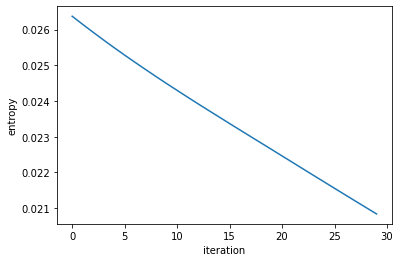

In [28]:
example_ind = 2

# the probabilities below this threshold are cut to zero
pred_threshold = 0.0
# number of entropy minimization iterations used by the "uber_net"
n_optim_iter = 30

example_files = ['GalNact_NL1b_CS2_P5_CH11_Gain550',
                 'ENDO_NL1ab_CS2_P2_CH11_Gain550',
                 'KDEL_NL4_CS1_P3_CH11_Gain550',
                 'TOM70_NRXN3Beta-_CS1_P1_CH11_Gain550']

image_file_name = f"{data_dir}/{example_files[example_ind]}.lsm"

cropped_name, protein_name, false_color_stack, cell_halo_false_color_stack, unprocessed_false_color_stack,\
entropy_stack, entropy_iter_stack, accuracy = predict_image_from_file(file_name=image_file_name,
                                                                      pred_threshold=pred_threshold,
                                                                      n_optim_iter=n_optim_iter)

plt.plot(entropy_iter_stack[0])
plt.xlabel("iteration")
plt.ylabel("entropy")

if save_figures:
    tifffile.imwrite(f"{output_dir}/false_color_{cropped_name}.tiff", 
                     data=cell_halo_false_color_stack, compress=6, photometric='rgb')

(-0.5, 511.5, 511.5, -0.5)

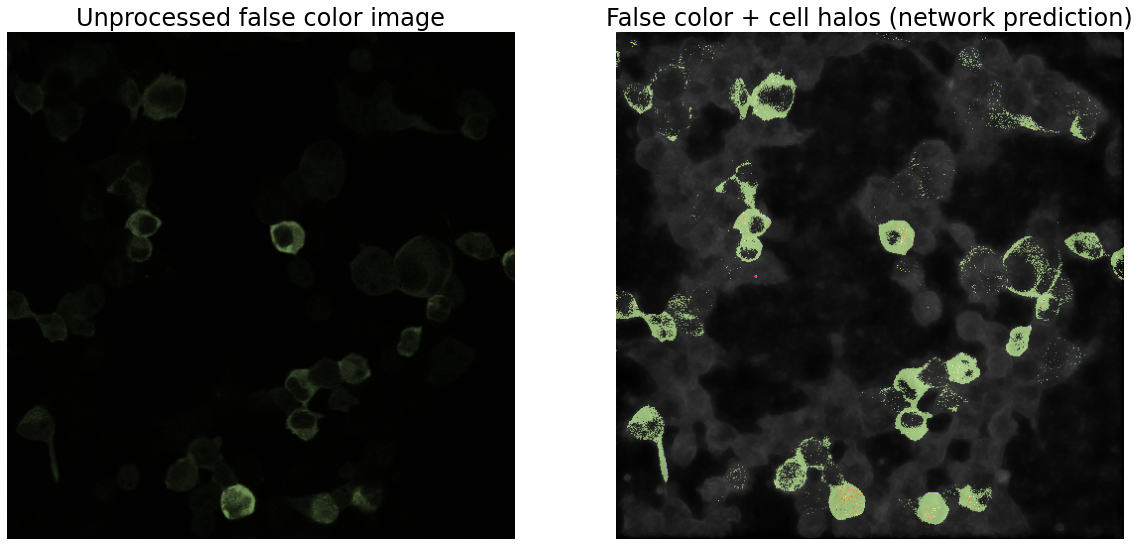

In [29]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(unprocessed_false_color_stack[0, :, :] / 65535.0)
ax.set_title("Unprocessed false color image", fontsize=24)
ax.axis('off')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(cell_halo_false_color_stack[0, :, :] / 65535.0)
ax.set_title("False color + cell halos (network prediction)", fontsize=24)
ax.axis('off')